# This file is responsible for computing syntactic similarity measures and analyze their relationship with writing scores
## Import library

In [1]:
%run functions

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Import data 

In [ ]:
loader = DataLoader()
d =loader.GetData('final')

### Load similarity matrices

In [4]:
f = np.load('features/final_winter_sent.npz')

In [5]:
sim_list = [f[a] for a in f.files]

## Get mean, max and min values of sim matrices

In [6]:
sim_raw_list = []
for n in f.files:
    values = []
    m = f[n]
    for row in range(len(m)):
        for col in range(row+1,len(m)):
            values.append(m[row,col])
    sim_raw_list.append(np.array(values))

In [7]:
sim_mean = []
sim_max = []
sim_min = []
for matrix in sim_raw_list:
    if len(matrix) > 1:
        sim_mean.append(np.average(matrix))
        sim_max.append(np.max(matrix))
        sim_min.append(np.min(matrix))
    else:
        sim_mean.append(0)
        sim_max.append(0)
        sim_min.append(0)

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Get cluster data

In [8]:
cluster_num = []
cluster_avg = []
for k in range(len(sim_list)):
    sim = sim_list[k]
    if len(sim) > 1:
        sim_thres = sim.copy()
        for i in range(len(sim_thres)):
            for j in range(len(sim_thres)):
                if sim_thres[i,j] <= np.percentile(np.array(sim_raw_list[k]),50):
                    sim_thres[i,j] = 0
        res = mcl.run_mcl(sim_thres,inflation=2)
        clusters = mcl.get_clusters(res)
        cluster_num.append(len(clusters))
        cluster_avg.append(len(sim)/len(clusters))
    else:
        cluster_num.append(0)
        cluster_avg.append(0)

### Add data to dataframe

In [9]:
d = loader.GetData('final')
d['mean'] = sim_mean
d['max'] = sim_max
d['min'] = sim_min
d['cluster_num'] = cluster_num
d['cluster_avg'] = cluster_avg                                                

### Select non-zero scores, and add level percentile

In [10]:
d = shuffle(d,random_state=1000)
d = d.loc[d['score'] > 0]
d.loc[:,'Top n% in scores'] = 0
percentiles = []
for i in range(10,100,10):
    percentiles.append(np.percentile(d['score'],i))
d.loc[d['score'] <= percentiles[0],'Top n% in scores'] = '100'
for i in range(8):
    d.loc[(d['score'] <= percentiles[i+1]) & (d['score'] > percentiles[i]),'Top n% in scores'] = str((10-i-1)*10)
d.loc[d['score'] > percentiles[-1],'Top n% in scores'] = '10'

In [11]:
ind = list(d.index)
trainIn,testIn = ind[:2838],ind[2838:]

## Linear regression

In [12]:
model = pg.linear_regression(d.loc[trainIn,['mean','min','max','cluster_num','cluster_avg']],d.loc[trainIn,'score'],relimp=True,remove_na=True)
model

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,7.368764,0.188104,39.173780,1.335762e-268,0.225353,0.223986,6.999928,7.737600,NaN,NaN
1,mean,-3.319150,1.226092,-2.707097,6.828183e-03,0.225353,0.223986,-5.723274,-0.915027,0.023507,10.430993
2,min,-9.253533,1.488839,-6.215267,5.877516e-10,0.225353,0.223986,-12.172852,-6.334214,0.036619,16.249426
3,max,-0.405099,0.246985,-1.640178,1.010792e-01,0.225353,0.223986,-0.889388,0.079189,0.003429,1.521473
4,cluster_num,0.442146,0.019755,22.381226,2.695588e-102,0.225353,0.223986,0.403410,0.480882,0.125448,55.667237
5,cluster_avg,0.530923,0.034305,15.476752,6.277483e-52,0.225353,0.223986,0.463658,0.598187,0.036351,16.130870


In [21]:
TrainX,TestX = [list(d.loc[i,['mean','min','max','cluster_num','cluster_avg']]) for i in trainIn],[list(d.loc[i,['mean','min','max','cluster_num','cluster_avg']]) for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

In [22]:
model = linear_model.LinearRegression()
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

#### Performance on test data

In [23]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(1.234732554424816, 0.21697054222733025, 0.21351183280216413)

#### Performance on train data

In [24]:
mean_squared_error(TrainY,PredTrainY,squared=False),explained_variance_score(TrainY,PredTrainY),r2_score(TrainY,PredTrainY)

(1.1836025414583373, 0.2253533019206695, 0.2253533019206695)

### Plot some results

In [38]:
sns.set_theme(style='darkgrid')
c = sns.diverging_palette(20, 220, as_cmap=True)sns.diverging_palette(20, 220, as_cmap=True)

<AxesSubplot: xlabel='min', ylabel='Percent'>

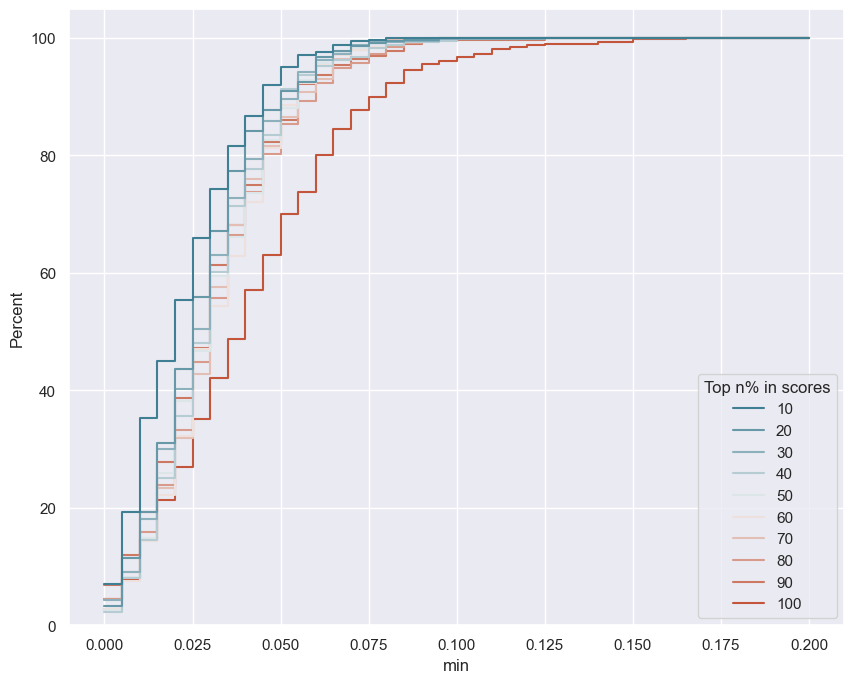

In [70]:
fig, ax = plt.subplots(figsize=(10,8))  
sns.histplot(d,x='min',hue='Top n% in scores',cumulative=True,stat='percent',common_norm = False, binwidth=0.005,binrange=(0,0.2),fill=False,element = 'step',hue_order=[str(i) for i in range(10,110,10)],palette=sns.diverging_palette(220, 20, n=10))

<AxesSubplot: xlabel='cluster_num', ylabel='Percent'>

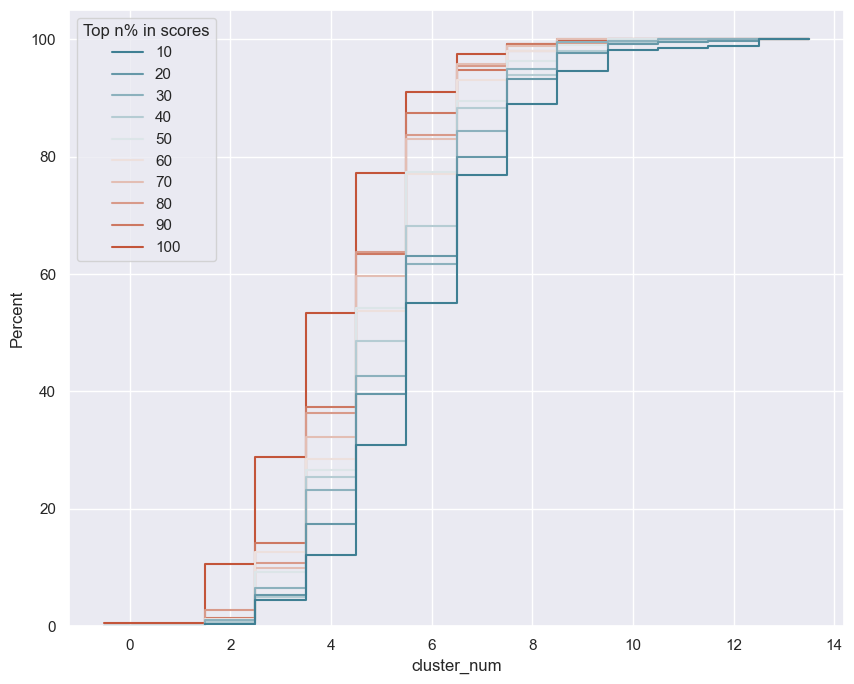

In [72]:
fig, ax = plt.subplots(figsize=(10,8))  
sns.histplot(d,x='cluster_num',hue='Top n% in scores',cumulative=True,stat='percent',discrete=True, common_norm = False, binwidth=1,fill=False,element = 'step',hue_order=[str(i) for i in range(10,110,10)],palette=sns.diverging_palette(220, 20, n=10))

## Some examples: 2888,2087,1067

In [47]:
sim = f[f.files[2087]]

In [48]:
sim_thres = sim.copy()
for i in range(len(sim_thres)):
    for j in range(len(sim_thres)):
        if sim_thres[i,j] <= np.percentile(sim_raw_list[2087],50):
            sim_thres[i,j] = 0

#### Visualize similarity matrix

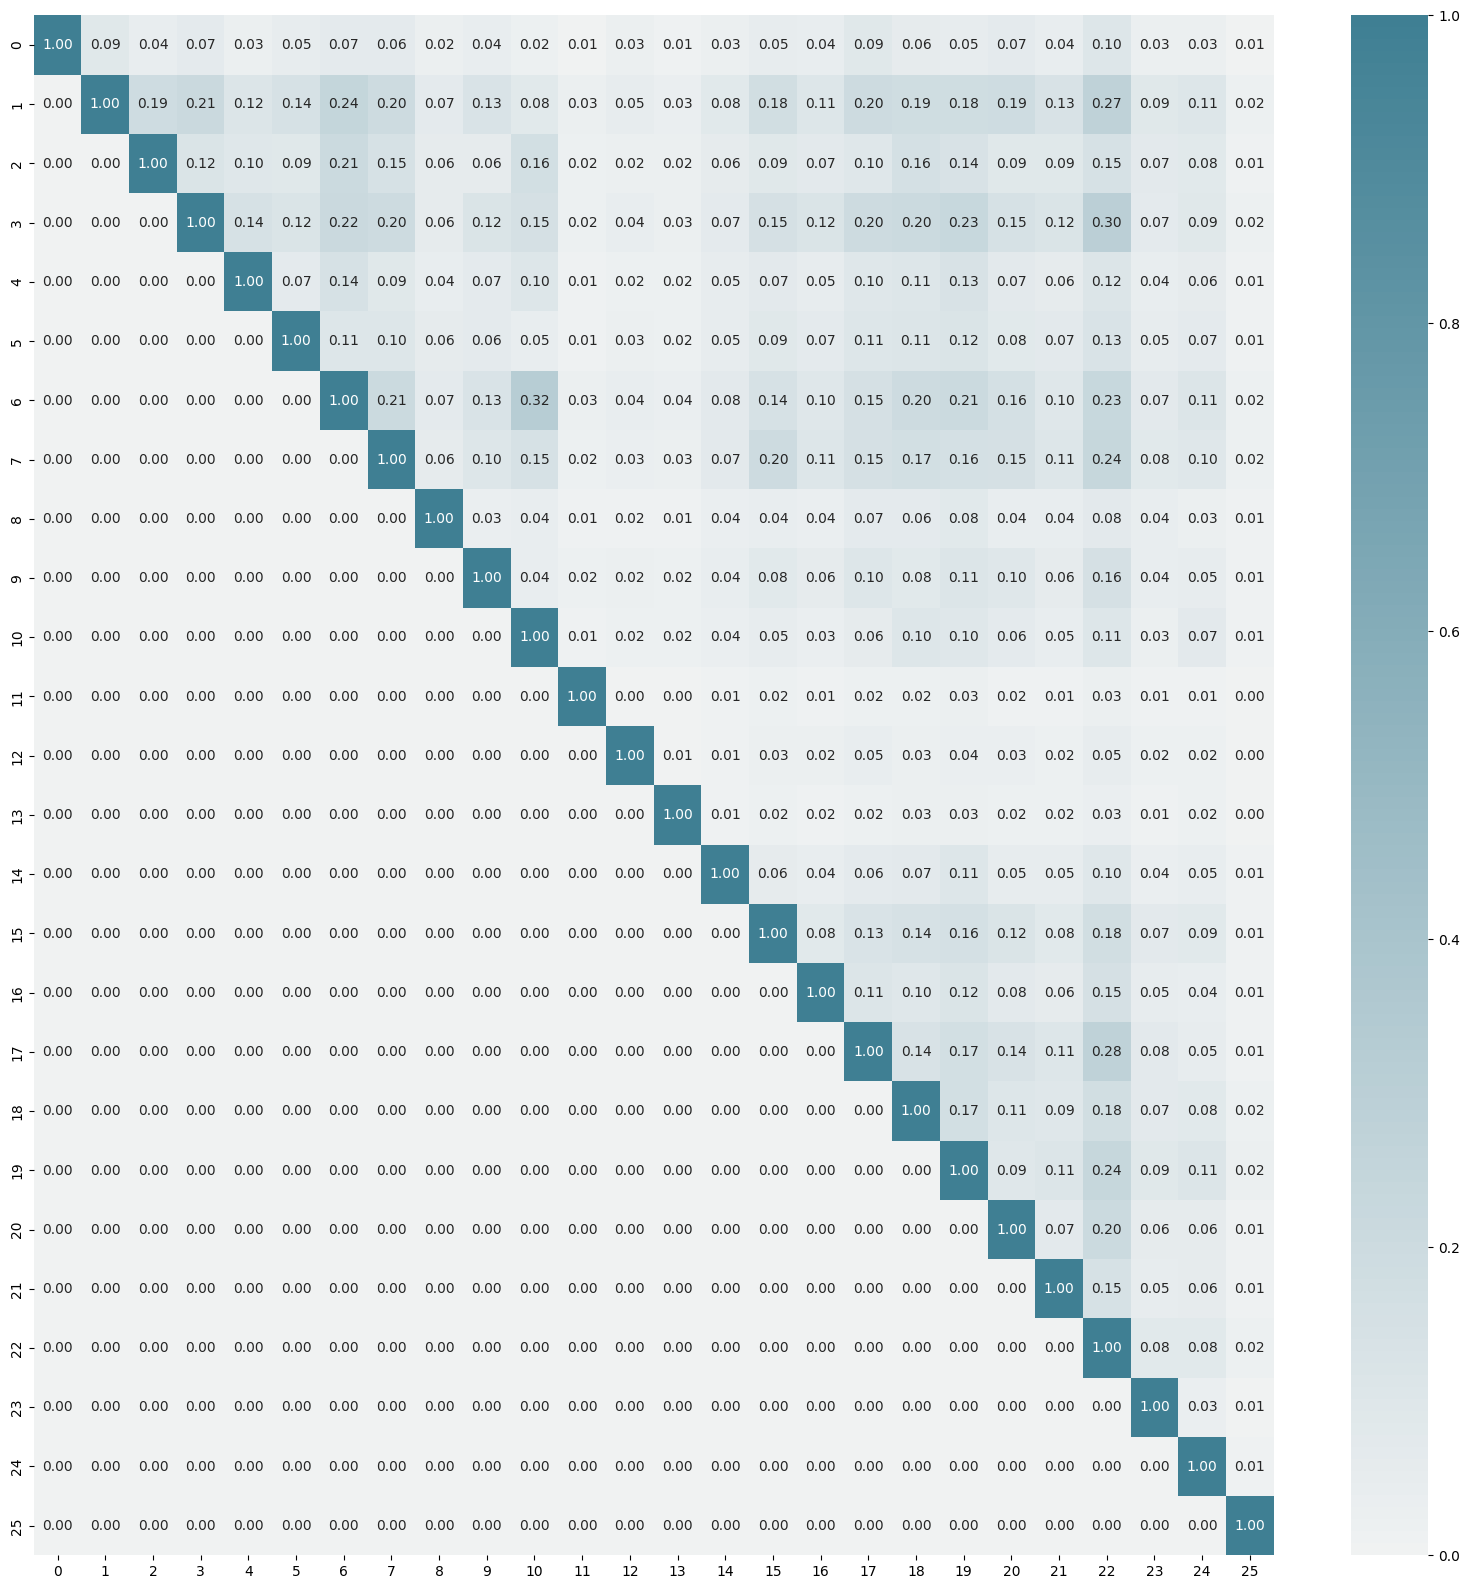

In [51]:
c = sns.diverging_palette(20, 220, as_cmap=True)
fig, ax = plt.subplots(figsize=(20,20))   
g = sns.heatmap(sim,vmin=0,vmax=1,center=0,annot=True,fmt='.2f',cmap=c)

In [52]:
np.fill_diagonal(sim_thres,0)
res = mcl.run_mcl(sim_thres,inflation=2)
clusters = mcl.get_clusters(res)

In [53]:
len(clusters)

13

#### Visualize sentence clusters

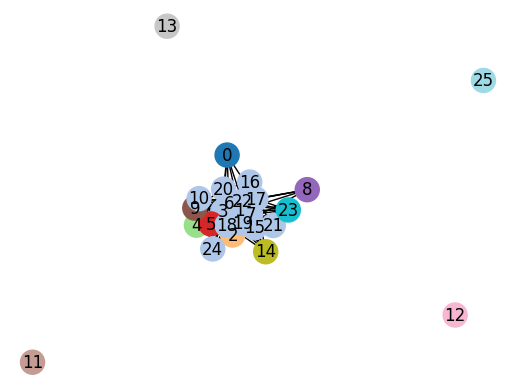

In [57]:
mcl.draw_graph(sim_thres,clusters)